In [1]:
import os

import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
f = gzip.GzipFile(r"../../Data/Train1FactorTermStructure.txt.gz", "r")
dat=np.load(f)
xx=dat[:,:11]
yy=dat[:,11:]
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

print(xx.shape)
print(yy.shape)

(80000, 11)
(80000, 88)


In [2]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


x_train, x_test, y_train, y_test = train_test_split(
    xx, yy, test_size=0.15, random_state=42)
scale_x = StandardScaler()
scale_y=  StandardScaler()

def xtransform(x_train, x_test):
    return [scale_x.fit_transform(x_train),scale_x.transform(x_test)]

def xinversetransform(x):
    return scale_x.inverse_transform(x)

def ytransform(y_train,y_test):
    return [scale_y.fit_transform(y_train),scale_y.transform(y_test)]

def yinversetransform(y):
    return scale_y.inverse_transform(y)

# Upper and lower bounds used in the training set
ub=np.array([0.16,0.16,0.16,0.16,0.16,0.16,0.16,0.16,4,10,-0.1])
lb=np.array([0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.5,0.0,-0.95])

def myscale(x):
    return (x - (ub+lb)*0.5)*2/(ub-lb)
def myinverse(x):
    return x*(ub-lb)*0.5+(ub+lb)*0.5

x_train_transform = myscale(x_train)
x_test_transform = myscale(x_test)
[y_train_transform,y_test_transform] = ytransform(y_train,y_test)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"device is {device}")

train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_train_transform).to(device=device),
                                               torch.from_numpy(y_train_transform).to(device=device))
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_test_transform).to(device=device),
                                              torch.from_numpy(y_test_transform).to(device=device))


train_data = (torch.from_numpy(x_train_transform).to(device=device),torch.from_numpy(y_train_transform).to(device=device))
test_data = (torch.from_numpy(x_test_transform).to(device=device),torch.from_numpy(y_test_transform).to(device=device))

data_loader = torch.utils.data.DataLoader(train_dataset,batch_size =64,shuffle=True)

device is cuda


In [3]:
import sys
sys.path.append('../../')  # Add the parent directory to the Python path

from torch_NN.nn import ResNN_pricing

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

hyperparas = {'input_dim':11,'hidden_dim':128,'hidden_nums':20,'output_dim':88,'block_layer_nums':3}

model = ResNN_pricing(hyperparas=hyperparas).to(device=device,dtype=torch.float64)

loss_MSE = nn.MSELoss()
optim_Adam = torch.optim.Adam(model.parameters(),lr= 0.0001)

-----------------------Epoch: 0----------------------------------
Batch: 0,train loss is: 20.208752506744585
test loss is 17.776601863161837
Batch: 100,train loss is: 0.8061473599006306
test loss is 0.7158688805823933
Batch: 200,train loss is: 0.299150774640862
test loss is 0.3282649607486988
Batch: 300,train loss is: 0.19165265454708572
test loss is 0.1916159346818677
Batch: 400,train loss is: 0.12313541256392202
test loss is 0.13723446912456025
Batch: 500,train loss is: 0.10764153517124919
test loss is 0.10050618171082323
Batch: 600,train loss is: 0.08930086398049021
test loss is 0.07974221575924126
Batch: 700,train loss is: 0.05785272391457137
test loss is 0.06410904984965032
Batch: 800,train loss is: 0.058640991522242135
test loss is 0.057822473600972105
Batch: 900,train loss is: 0.053020321141474695
test loss is 0.04699380651595815
Batch: 1000,train loss is: 0.040456748982156523
test loss is 0.0431212644390558
-----------------------Epoch: 1----------------------------------
Batch

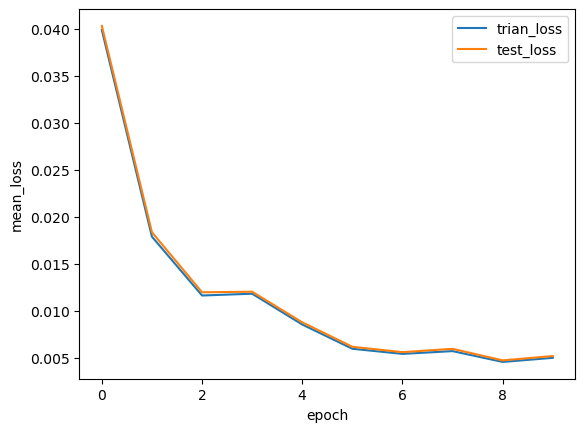

In [4]:
from torch_NN.train import train_model

train_model(loss_MSE,optim_Adam,model,data_loader,train_data,test_data,10)

-----------------------Epoch: 0----------------------------------
Batch: 0,train loss is: 0.005108609111945267
test loss is 0.0036581292401549836
Batch: 100,train loss is: 0.0029216687264917813
test loss is 0.0032746905133351637
Batch: 200,train loss is: 0.003373071181919822
test loss is 0.0032271424903620454
Batch: 300,train loss is: 0.0027536388831863913
test loss is 0.0032244003976551103
Batch: 400,train loss is: 0.0028366703027213483
test loss is 0.0031986791247462475
Batch: 500,train loss is: 0.0028174844646491554
test loss is 0.0031905923226054
Batch: 600,train loss is: 0.0038063601910656468
test loss is 0.003190879829272284
Batch: 700,train loss is: 0.0029999736439389286
test loss is 0.0031815828117949005
Batch: 800,train loss is: 0.0031016809055288293
test loss is 0.003166981327450814
Batch: 900,train loss is: 0.004244706192805244
test loss is 0.0031373896497510646
Batch: 1000,train loss is: 0.0030287625259411127
test loss is 0.003160482684395858
-----------------------Epoch: 1

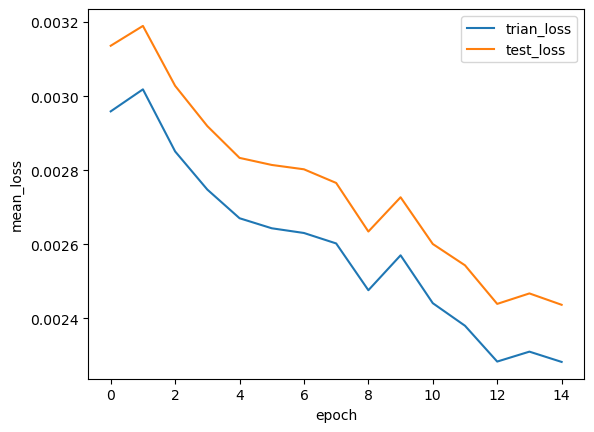

In [5]:
optim_Adam = torch.optim.Adam(model.parameters(),lr= 0.00001)

train_model(loss_MSE,optim_Adam,model,data_loader,train_data,test_data,15)

In [6]:
torch.save(model.state_dict(),'../../Data/YU/1piecewiseBergomi.pth')